In [1]:
import os
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from adcircpy import AdcircMesh
from adcircpy.mesh.base import Elements

In [2]:
# Paths to the input/output files
basedir = "/home/sbunya/GitHub/adcircutils/adcircutils/vewchannel/examples/example1"
f14file = os.path.join(basedir, "fort_without_vews.14")
vewfile = os.path.join(basedir, "vewstings.yaml")

In [3]:
# Load the YAML file
with open(vewfile, 'r') as file:
    vewdata = yaml.safe_load(file)
vewstrings = vewdata['vewstrings']

In [5]:
# Creating a new mesh with bank nodes
def add_vewstring(mesh, vewstring):
    # Dictionary to store mapping of node orders in an element
    map_elem_node_prev = {0: 2, 1: 0, 2: 1}
    map_elem_node_next = {0: 1, 1: 2, 2: 0}

    # Create bank nodes and add them to the mesh
    nn = mesh.nodes.shape[0]
    map_node = {}
    id_new = []
    x_new = []
    y_new = []
    z_new = []

    if len(vewstring) < 4 or (len(vewstring) < 3 and vewstring[0]['node_id'] == vewstring[-1]['node_id']):
        raise ValueError(
            "The length of a vewstring is {:d}. It should be greater than 2 for an open node string \
             and should be greater than 2 for a closed node string.".format(len(vewstring)))

    # Add the second last node to the beginning and the second node to the end
    # if it is the same as the last node. This ensures the beginning node is also duplicated.
    if vewstring[0]['node_id'] == vewstring[-1]['node_id']:
        vewstring.insert(0, vewstring[-2])
        vewstring.append(vewstring[2])

    # Add the bank nodes
    for nodedata in vewstring[1:-1]:
        node = nodedata['node_id']
        if node in map_node.keys(): # Skip if the node is already added. This occurs when the node string is closed.
            continue
        nn += 1
        map_node.update({node: nn})
        id_new.append(nn)
        x_new.append(mesh.x[node])
        y_new.append(mesh.y[node])
        z_new.append(nodedata['bank_elevation'])

    nodes_new = pd.concat([mesh.nodes, pd.DataFrame(index=id_new, data={'x': x_new, 'y': y_new, 'value_1': z_new})])

    # Update elements
    elements = mesh.elements.elements
    elements_new = elements.copy()
    nodestring = [vewstring[i]['node_id'] for i in range(len(vewstring))]
    node_elements = mesh.node_elements.copy()
    
    # Detaching the elements along the vewstring
    for i in range(1, len(nodestring)-1):
        node1 = nodestring[i-1]
        node2 = nodestring[i]
        node3 = nodestring[i+1]
        
        # Find the elements that are on the right side of the line segment that is defined by node1, node2, and node3
        eids = [int(node) + 1 for node in node_elements[node2-1]]

        # Starting from the element that contains node1, find the elements counterclose-wise until it reaches node3
        curr_node = node1
        eids_right = []
        while curr_node != node3:
            for eid in eids:
                elem_nodes = [int(e) for e in elements.loc[eid].to_list()[1:4]]
                if curr_node in elem_nodes:
                    curr_index = elem_nodes.index(curr_node)
                    if elem_nodes[map_elem_node_prev[curr_index]] == node2:
                        break
            eids_right.append(eid)
            curr_node = elem_nodes[map_elem_node_next[curr_index]]
        
        for eid in eids_right:
            elements_new.loc[eid, elements.columns[elements.loc[eid] == node2]] = map_node[node2]
    
    # Update the node ids in the boundary conditions
    boundaries = mesh.boundaries.to_dict()
    boundaries_new = mesh.boundaries.to_dict().copy()
    for ibtype in boundaries.keys():
        for i in range(len(boundaries[ibtype])):
            # Drop the bank nodes in the boundary table
            if ibtype is None: # open boundary
                pass
            elif ibtype.endswith('2'): # flow boundary
                pass
            elif ibtype.endswith('4'): # weir boundary
                pass
            elif ibtype.endswith('0'): # land boundary
                dfbnd = pd.DataFrame(boundaries[ibtype][i]['node_id'])
                dfbnd.replace(map_node, inplace=True)
                boundaries_new[ibtype][i]['node_id'] = dfbnd.values.tolist()
            else:
                pass
                                    
    # Add a vew boundary
    vew_node_id = [(str(map_node[nodestring[i]]), str(nodestring[i])) for i in range(1, len(nodestring)-1)]
    vew_barrier_height = [vewstring[i]['bank_elevation'] + 1e-3 for i in range(1, len(nodestring)-1)]
    vew_subcritical_flow_coefficient = [1.0 for _ in range(1, len(nodestring)-1)]
    vew_supercritical_flow_coefficient = [1.0 for _ in range(1, len(nodestring)-1)]        
    vewboundary_new = \
        {'node_id': vew_node_id,
         'barrier_height': vew_barrier_height,
         'subcritical_flow_coefficient': vew_subcritical_flow_coefficient,
         'supercritical_flow_coefficient': vew_supercritical_flow_coefficient}
    
    vewboundaries_new = boundaries_new['64'] if '64' in boundaries_new.keys() else []
    vewboundaries_new.append(vewboundary_new)
    
    boundaries_new.update({'64': vewboundaries_new})
    
    # Return the updated mesh   
    return AdcircMesh(nodes=nodes_new, elements=elements_new, boundaries=boundaries_new)

def add_vewstrings(mesh, vewstrings):
    for vewstring in vewstrings:
        mesh = add_vewstring(mesh, vewstring)
    return mesh

# Load the mesh file
mesh = AdcircMesh.open(f14file)
mesh_new = add_vewstrings(mesh, vewstrings)
mesh_new.description = "Generated by add_vew_to_mesh"

# Save the mesh file
f14file_out = os.path.join(basedir, "fort_with_vews.14")
mesh_new.write(f14file_out, overwrite=True)

/home/sbunya/GitHub/adcircpy/adcircpy/mesh/parsers/grd.py:277: UserWarning: File does not contain CRS information and no CRS was given: "/home/sbunya/GitHub/adcircutils/adcircutils/vewchannel/examples/example1/fort_without_vews.14"
  warnings.warn(


In [6]:
print(mesh.nodes)
print(mesh_new.nodes)

          x       y  value_1
id                          
1   -1500.0     0.0     -4.0
2   -1400.0     0.0     -4.0
3   -1300.0     0.0     -4.0
4   -1200.0     0.0     -4.0
5   -1100.0     0.0     -4.0
..      ...     ...      ...
647  1100.0  2000.0      1.0
648  1200.0  2000.0      1.0
649  1300.0  2000.0      1.0
650  1400.0  2000.0      1.0
651  1500.0  2000.0      1.0

[651 rows x 3 columns]
          x       y  value_1
1   -1500.0     0.0     -4.0
2   -1400.0     0.0     -4.0
3   -1300.0     0.0     -4.0
4   -1200.0     0.0     -4.0
5   -1100.0     0.0     -4.0
..      ...     ...      ...
772  -300.0  1000.0      2.0
773  -300.0   900.0      2.0
774  -300.0   800.0      2.0
775  -300.0   700.0      2.0
776  -300.0   600.0      1.0

[776 rows x 3 columns]


<Axes: >

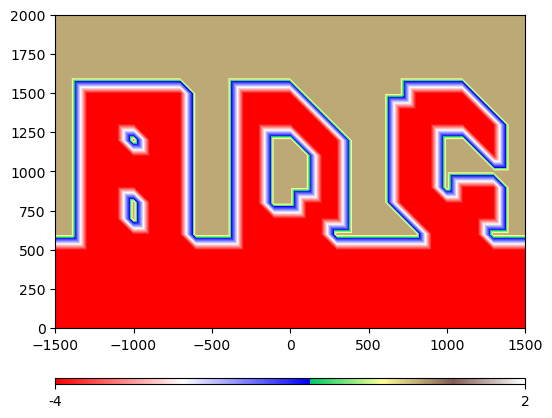

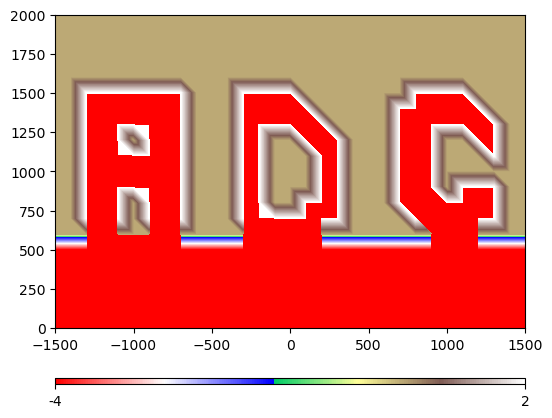

In [7]:
# Plotting the original and new mesh
mesh.make_plot(vmin=-4, vmax=2)
mesh_new.make_plot(vmin=-4, vmax=2)

In [8]:
mesh_new._values

,value_1
1,-4.0
2,-4.0
3,-4.0
4,-4.0
5,-4.0
...,...
772,2.0
773,2.0
774,2.0
775,2.0


In [6]:
# f14file2 = "/home/sbunya/GitHub/adcircutils/adcircutils/vewchannel/examples/example3/ncv27.05ca1.grd"
# f13file2 = "/home/sbunya/GitHub/adcircutils/adcircutils/vewchannel/examples/example3/ncv27.05ca1.13"
# mesh2 = AdcircMesh.open(f14file2)
# mesh2.import_nodal_attributes(f13file2)
# condensed_nodes = mesh2.nodal_attributes.get_attribute('condensed_nodes')
# condensed_nodes['values'].shape, mesh2.nodes.shape